In [2]:
import json
import os

import pandas as pd
import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt

In [3]:
DATA_DIR = 'data'

def get_ads(data_dir=DATA_DIR):
    ads = []
    for data_filename in os.listdir(data_dir):
        path = os.path.join(data_dir, data_filename)
        with open(path) as data_file:
            raw = json.load(data_file)
            ads += [json.loads(ad) for ad in raw]
    return pd.DataFrame(ads)

In [4]:
# Get ads from files
ads = get_ads()
ads['price_usd'] /= 100
print('ads: Length with duplicates:    ', len(ads))

# Drop duplicates
ads = ads.drop_duplicates(['ad_id'])
print('ads: Length without duplicates: ', len(ads))

ads.head()

ads: Length with duplicates:     7200
ads: Length without duplicates:  7156


ad_id                          ad_link  \
0  60958462  https://re.kufar.by/vi/60958462   
1  85326940  https://re.kufar.by/vi/85326940   
2  85326307  https://re.kufar.by/vi/85326307   
3  85325201  https://re.kufar.by/vi/85325201   
4  85322388  https://re.kufar.by/vi/85322388   

                                             address  area bathroom category  \
0            Минск улица Фрунзе 3 Партизанский район  25.0        2     1010   
1                   Гродно улица Ольги Соломовой 118   9.0     None     1040   
2                               Гродно улица Зана 12   9.0        2     1010   
3   Клецк улица Победы Клецкий район Минская область  95.0     None     1030   
4  Молодечно Молодечненский район площадь Старое ...  16.0     None     1040   

   company_ad condition                              coordinates currency  \
0        True         1                 [27.5740743, 53.9064958]      EUR   
1       False         1         [23.780150756720978, 53.6552404]      BYR   
2       False         1        [23.815819207003322, 53.66844195]      BYR   
3       False      None               [26.64206265, 53.06555345]      BYR   
4       False         1  [26.87082988050163, 54.318075750000006]      BYR   

   ...                  list_time       name price_byn  price_usd  region  \
0  ...  2019-10-21T17:55:21+00:00  АН Юриэлт    163660     775.46       7   
1  ...  2019-10-21T17:44:49+00:00    Андрей       2000       9.48       3   
2  ...  2019-10-21T17:35:09+00:00     Марина      2000       9.48       3   
3  ...  2019-10-21T17:18:02+00:00    Татьяна     20000      94.76       5   
4  ...  2019-10-21T16:31:14+00:00   Виктория     10000      47.38       5   

   remuneration_type  rent_type  rooms  \
0                  1        1.0    2.0   
1                  1        NaN    2.0   
2                  1        2.0    2.0   
3                  1        NaN    NaN   
4                  1        NaN    1.0   

                                             subject type_  
0  2-комнатная квартира на ул.Фрунзе, 3. Центр Ми...   let  
1                          Квартира на часы и суткти   let  
2                           Квартира на часы и сутки   let  
3                                      СДАМ В АРЕНДУ   let  
4                                       Сдам комнату   let  

[5 rows x 21 columns]

In [5]:
# Convert [lat, lng] list to pd.DataFrame
points = pd.DataFrame([
    (idx, coord[0], coord[1])
    for idx, coord in ads['coordinates'].iteritems()
    if coord is not None
], columns=['idx', 'latitude', 'longitude'])

# Restore original indexing
points = points.set_index(['idx'])

# Display tail
points.tail()

latitude  longitude
idx                       
7195  26.838911  54.307333
7196  31.389038  53.552398
7197  30.267789  55.195031
7198  23.705430  52.070091
7199  23.693833  52.085827

In [6]:
def gaussian1d(x, μ, σ_sqr):
    return np.exp( -(x - μ)**2 / (2*σ_sqr) ) / np.sqrt(2 * np.pi * σ_sqr)
     
    
def gaussianNd(x, μ, σ_sqr):
    prd = np.array([
        gaussian1d(xi, μi, σ_sqr_i) 
        for xi, μi, σ_sqr_i in zip(x, μ, σ_sqr)])
    return np.product(prd, axis=0)

Text(0.5,1,'Distribution')

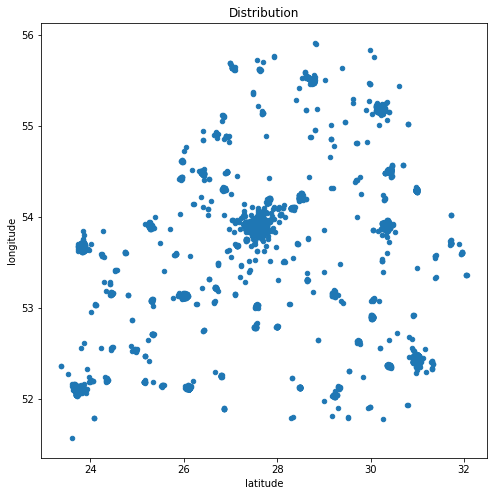

In [7]:
_, ax = plt.subplots(1, 1, figsize=(8, 8))

X = points['latitude'].values
Y = points['longitude'].values

μ = points.mean().values
σ_sqr = points.var().values

# Eval chart bounds
xmin, xmax = X.min() - .1, X.max() + .1
ymin, ymax = Y.min() - .1, Y.max() + .1

# Create grid
x = np.arange(xmin, xmax, .01)
y = np.arange(ymin, ymax, .01)
xx, yy = np.meshgrid(x, y)

# Eval Z
zz = gaussianNd([xx, yy], μ, σ_sqr)

# Plot chart
# cs = ax.contour(xx, yy, zz)
# ax.clabel(cs, fontsize=10)

points.plot.scatter(x='latitude', y='longitude', ax=ax)
ax.set_title('Distribution')

In [8]:
ads.columns

Index(['ad_id', 'ad_link', 'address', 'area', 'bathroom', 'category',
       'company_ad', 'condition', 'coordinates', 'currency', 'list_id',
       'list_time', 'name', 'price_byn', 'price_usd', 'region',
       'remuneration_type', 'rent_type', 'rooms', 'subject', 'type_'],
      dtype='object')

(360.29970647098065, 318.8293487906149)

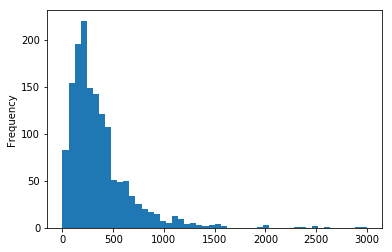

In [9]:
flats = ads[ads['category'] == '1010']
flats = flats[flats['rent_type'] == 1]
flats = flats[flats['price_usd'] != 0]

flats = flats[flats['price_usd'] < 3000]
flats['price_usd'].plot.hist(bins=50)

flats['price_usd'].mean(), flats['price_usd'].std()

In [10]:
category_map = {
    '1010': 'flat',
    '1020': 'cottage',
    '1030': 'garage',
    '1040': 'room',
    '1050': 'industrial',
}

categ_df = ads.groupby('category')['price_usd', 'area'].agg(['count', 'mean', 'median', 'std'])
categ_df.index = categ_df.index.map(category_map)
categ_df

price_usd                                     area             \
               count         mean median            std count       mean   
category                                                                   
flat            3488   319.781428  26.06    5609.348238  3488  23.125860   
cottage          525   690.020990  23.69    8458.368901   525  48.920000   
garage           474    99.449325  24.64     488.725450   474  26.073840   
room             580   130.161190   4.74    2185.045742   580  25.001724   
industrial      2089  5200.667209   4.50  146804.120480  2089  23.988033   

                              
           median        std  
category                      
flat         22.0  21.614819  
cottage      30.0  45.503180  
garage       22.0  27.719694  
room         18.5  26.704647  
industrial   18.0  27.599148

In [11]:
region_map = {
    1: 'Brest',
    2: 'Gomel',
    3: 'Grodno',
    4: 'Mogilev',
    5: 'Minsk countryside',
    6: 'Videbsk',
    7: 'Minsk',
}

reg_df = ads.groupby('region')['price_usd', 'area'].agg(['count', 'mean', 'median', 'std'])
reg_df.index = reg_df.index.map(region_map)
reg_df

price_usd                                     area  \
                      count         mean median            std count   
region                                                                 
Brest                  1146  4414.726675  11.85  139988.944803  1146   
Gomel                   814    84.510147  15.64     265.343200   814   
Grodno                  752   180.054614   9.48    2555.936714   752   
Mogilev                 741    79.367449   6.00     516.563872   741   
Minsk countryside       611   804.409771  23.69    9076.259831   611   
Videbsk                 900   412.954144  12.79   10581.601023   900   
Minsk                  2192  2864.530762  75.81  101497.682755  2192   

                                                
                        mean median        std  
region                                          
Brest              12.753927    1.0  18.776846  
Gomel              12.910319    5.0  20.969387  
Grodno             20.699468    9.0  22.462754  
Mogilev            21.577598   13.0  20.278693  
Minsk countryside  72.252046   45.0  50.972850  
Videbsk            28.896667   18.0  26.998236  
Minsk              25.768248   26.0   2.944510